In [1]:
import cv2
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pydicom
from tqdm import tqdm
import scipy.io as sio

In [3]:
#import sys

#!$sys.executable -m pip install tensorflow

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../rsna")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
!git clone https://github.com/pdollar/coco.git
import coco
%matplotlib inline


Using TensorFlow backend.
fatal: destination path 'coco' already exists and is not an empty directory.


In [3]:
print(ROOT_DIR)

C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna


In [4]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [5]:
# DO NOT RUN EVERY SINGLE TIME!!!!
#os.chdir(ROOT_DIR)
#!git clone https://github.com/matterport/Mask_RCNN.git
#os.chdir('Mask_RCNN')
#!python setup.py -q install --user

In [6]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [7]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, "stage_1_train_images")
print(train_dicom_dir)
print(test_dicom_dir)

C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\stage_1_train_images
C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\stage_1_train_images


In [8]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

In [9]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    #NUM_CLASSES = 37  # COCO has 80 classes
    NUM_CLASSES = 2
    
class InferenceConfig(CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #chnage to 1, 20210318 #20210322 1=>2
#     IMAGE_META_SIZE=14
    NUM_CLASSES = 2
    MAX_GT_INSTANCES = 2 # effectively puts an upper limit to the number of ground-truth object instances per image.
    DETECTION_MAX_INSTANCES = 2 #a little faster but some instances not recognized
    
    #TRAIN_ROIS_PER_IMAGE = 50
    #BACKBONE = "resnet50" #not working at all!
    #RPN_ANCHOR_STRIDE = 2
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 500
#     IMAGE_MIN_DIM = 400 #really much faster but bad results
#     IMAGE_MAX_DIM = 512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    TOP_DOWN_PYRAMID_SIZE = 256
    
    STEPS_PER_EPOCH = 100 #20210322 
    
    RPN_TRAIN_ANCHORS_PER_IMAGE=200 ##hyperparameter #20210319 change from 6=>20 #20210320 => 50 #20210322 =>100
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD=0.1
    TRAIN_ROIS_PER_IMAGE=6
    POST_NMS_ROIS_INFERENCE=50
    POST_NMS_ROIS_TRAINING=100
    FPN_CLASSIF_FC_LAYERS_SIZE=1024



config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        2
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

In [10]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)
    

In [11]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'Train.csv'))
print(anns.head(6))
print(anns.shape)


                              patientId      x      y  width  height  Target
0  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
1  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
2  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
3  00c0b293-48e7-4e16-ac76-9269ba535a62  306.0  544.0  168.0   244.0       1
4  00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  511.0  206.0   284.0       1
5  00f08de1-517e-4652-a04f-d1dc9ee48593  181.0  184.0  206.0   506.0       1
(7206, 6)


In [12]:
fpp=[]
i=0
for index,row in anns.iterrows():
    fp = os.path.join(train_dicom_dir, row['patientId']+'.dcm')

    fpp.append(fp)
    i=i+1
    
fpptest=[]    
    
annstest = pd.read_csv(os.path.join(ROOT_DIR, 'Test.csv'))
i=0
for index,row in annstest.iterrows():
    fp = os.path.join(train_dicom_dir, row['patientId']+'.dcm')
    if i==0:
        fpptest.append(fp)
        i=i+1
    elif fp!=fpptest[i-1]:
        fpptest.append(fp)
        i=i+1
    

In [13]:
print(fpp[:6])
print(len(fpp))
print(fpptest[:6])
print(len(fpptest))

['C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00704310-78a8-4b38-8475-49f4573b2dbb.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00704310-78a8-4b38-8475-49f4573b2dbb.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00c0b293-48e7-4e16-ac76-9269ba535a62.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00c0b293-48e7-4e16-ac76-9269ba535a62.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00f08de1-517e-4652-a04f-d1dc9ee48593.dcm']
7206
['C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00436515-870c-4b36-a041-de91049b9ab4.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\009482dc-3db5-48d4-8580-5c89c4f01334.dcm', 'C:\\Users\\Yi-Yun\\Docum

In [14]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)


In [15]:
ds = pydicom.read_file(image_fps[2]) # read dicom image from filepath 
image = ds.pixel_array # get image array
ds
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

In [16]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(fpp[:]) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42) # 42=> 42 20210322
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))


6485 721


In [17]:
print(fpp[:10])

['C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00704310-78a8-4b38-8475-49f4573b2dbb.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00704310-78a8-4b38-8475-49f4573b2dbb.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00c0b293-48e7-4e16-ac76-9269ba535a62.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00c0b293-48e7-4e16-ac76-9269ba535a62.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00f08de1-517e-4652-a04f-d1dc9ee48593.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\00f08de1-517e-4652-a04f-d1dc9ee48593.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_train_images\\011d6f51-b732-4d45-a84d-90477325ef2d.dcm', 'C:\\Users\\Yi-Yun\\Documents\\

In [18]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [19]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    06fc2885-127a-4274-b20c-554d352ea21b
 x                                             197
 y                                             129
 width                                         297
 height                                        521
 Target                                          1
 Name: 120, dtype: object, patientId    06fc2885-127a-4274-b20c-554d352ea21b
 x                                             612
 y                                             292
 width                                         274
 height                                        418
 Target                                          1
 Name: 121, dtype: object]

In [20]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()
print(len(image_fps_val))


721


(1024, 1024, 3)
C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\stage_1_train_images\742365a8-d9a5-41e4-b8a3-24a03a894f9f.dcm
[1 1]


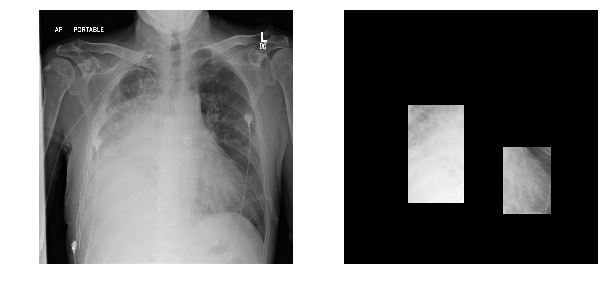

In [23]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [24]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)
# modeli = modellib.MaskRCNN(mode='inference', config=config, model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [25]:
COCO_MODEL_PATH

'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\mask_rcnn_coco.h5'

In [27]:
# Load weights trained on MS-COCO
# model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"])

# Load weights trained on OUR MODEL
model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"])


In [28]:
NUM_EPOCHS = 30

#LEARNING_RATE =0.0005
LEARNING_RATE =0.001

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='heads')




Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20210410T1559\mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeD

In [161]:
loss=[2.6173,1.7444,1.7495,1.6480,1.6192,1.6683,1.6106,1.6147,1.5816,1.5599,1.5625,1.5306,1.4918,1.5028,1.5752,1.5731,1.5665,1.5448,1.5321,1.5162,1.4478,1.4285,1.4350,1.4925,1.5073,1.4727,1.4367,1.4546,1.4843,1.4933]
len(loss)

30

In [163]:
valloss=[1.7463,1.3693,1.4507,1.1364,1.4265,1.9409,1.3201,1.5682,1.3942,1.9003,1.1477,1.3385,2.3061,1.9956,0.9456,1.5420,1.7889,1.6952,1.3491,1.1203,1.8905,2.0410,0.9160,1.6562,1.7950,1.0097,1.2374,1.0615,1.9842,1.3408]
len(valloss)

30

Text(0,0.5,'loss')

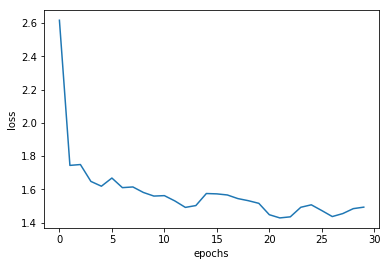

In [171]:
plt.plot(range(0,30),loss)
#plt.plot(range(0,30),valloss)
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.legend(["training loss","validation loss"])

In [21]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [25]:
OUR_MODEL_PATH='C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\logs\\coco20210410T1559\\mask_rcnn_coco_0030.h5'
print(OUR_MODEL_PATH)
model.load_weights(OUR_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"])

C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20210410T1559\mask_rcnn_coco_0030.h5


In [ ]:
NUM_EPOCHS = 30

##LEARNING_RATE =0.0005
LEARNING_RATE =0.0005

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all')




Starting at epoch 0. LR=0.0005

Checkpoint Path: C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20210414T1301\mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b     

100/100 [==============================] - 1602s 16s/step - loss: 1.7540 - val_loss: 1.9252

Epoch 2/30
100/100 [==============================] - 1597s 16s/step - loss: 1.5012 - val_loss: 1.2748
Epoch 3/30
100/100 [==============================] - 1582s 16s/step - loss: 1.4607 - val_loss: 1.7565
Epoch 4/30
100/100 [==============================] - 1577s 16s/step - loss: 1.4756 - val_loss: 1.8947
Epoch 5/30
100/100 [==============================] - 1570s 16s/step - loss: 1.4078 - val_loss: 1.4205
Epoch 6/30
100/100 [==============================] - 1591s 16s/step - loss: 1.4636 - val_loss: 0.8343
Epoch 7/30
100/100 [==============================] - 1575s 16s/step - loss: 1.3800 - val_loss: 1.3832
Epoch 8/30
100/100 [==============================] - 1575s 16s/step - loss: 1.3641 - val_loss: 2.1170
Epoch 9/30
100/100 [==============================] - 1572s 16s/step - loss: 1.4656 - val_loss: 1.5677
Epoch 10/30
100/100 [==============================] - 1575s 16s/step - loss: 1.347

In [30]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181201T2203
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181201T2208
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181201T2211
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181201T2218
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181201T2219
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181201T2224
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181201T2235
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181201T2236
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181202T0003
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181202T1356
No weight files in C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20181202T1508
No weight 

In [38]:
class DetectConfig(InferenceConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 #chnage to 1, 20210318

    DETECTION_MIN_CONFIDENCE = 0.5
#    DETECTION_NMS_THRESHOLD=0.1
    

detect_config = DetectConfig()

# Recreate the model in inference mode
modeli = modellib.MaskRCNN(mode='inference', 
                          config=detect_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
modeli.load_weights(model_path, by_name=True)


Loading weights from  C:\Users\Yi-Yun\Documents\Yi-Yun\Mask_RCNN\rsna\logs\coco20210410T1559\mask_rcnn_coco_0030.h5


In [39]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

10

*** No instances to display *** 

43

*** No instances to display *** 

46
106

*** No instances to display *** 

109
124


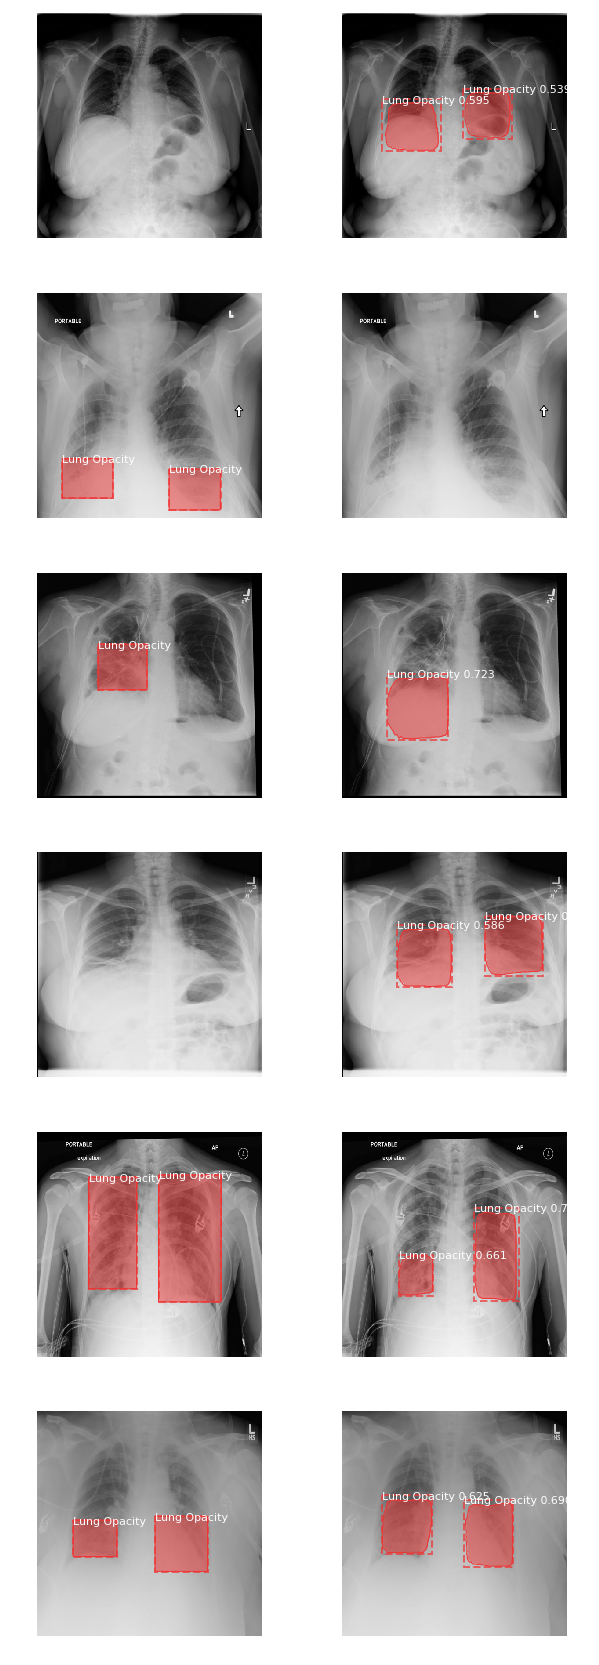

In [80]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

#     image_id = random.choice(dataset.image_ids)
    indexi=np.array([10.,43.,46.,106.,109.,124]).astype(int) 
#      47. 29.
    image_id = dataset.image_ids[indexi]
    image_id=image_id[i]
    print(image_id)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, detect_config, 
                               image_id, use_mini_mask=False)
        

    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = modeli.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])


In [42]:
print(gt_bbox)

[[247  82 330 182]
 [238 269 364 389]]


In [48]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(train_dicom_dir)
# ourtest_image_fps = get_dicom_fps(train_dicom_dir)
ourtest_image_fps =fpptest

In [49]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='predict.csv', min_conf=0.5): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = modeli.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str

        file.write(out_str+"\n")

In [50]:
print(fpptest)

['C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_test_images\\00436515-870c-4b36-a041-de91049b9ab4.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_test_images\\00436515-870c-4b36-a041-de91049b9ab4.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_test_images\\009482dc-3db5-48d4-8580-5c89c4f01334.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_test_images\\00aecb01-a116-45a2-956c-08d2fa55433f.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_test_images\\00aecb01-a116-45a2-956c-08d2fa55433f.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_test_images\\00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_test_images\\0100515c-5204-4f31-98e0-f35e4b00004a.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\Mask_RCNN\\rsna\\stage_1_test_images\\01027bc3-dc40-4165-a6c3-d6be2cb7ca34.dcm', 'C:\\Users\\Yi-Yun\\Documents\\Yi-Yun\\

In [53]:
sample_submission_fp = 'predict.csv'
predict(fpptest[:], filepath=sample_submission_fp)

100%|████████████████████████████████████████████████████████████████████████████| 7399/7399 [4:24:39<00:00,  2.15s/it]


In [54]:
output = pd.read_csv(sample_submission_fp, names=['id', 'pred_string'])
output.head(50)

,id,pred_string
0,00436515-870c-4b36-a041-de91049b9ab4,0.67 586 255 203 396 0.54 237 341 239 261
1,00436515-870c-4b36-a041-de91049b9ab4,0.67 586 255 203 396 0.54 237 341 239 261
2,009482dc-3db5-48d4-8580-5c89c4f01334,0.78 146 370 225 258 0.71 654 443 213 280
3,00aecb01-a116-45a2-956c-08d2fa55433f,0.69 537 304 214 365 0.52 248 354 223 329
4,00aecb01-a116-45a2-956c-08d2fa55433f,0.69 537 304 214 365 0.52 248 354 223 329
5,00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b,0.73 196 504 222 370 0.72 643 493 203 453
6,0100515c-5204-4f31-98e0-f35e4b00004a,0.78 599 340 221 305 0.75 277 260 188 345
7,01027bc3-dc40-4165-a6c3-d6be2cb7ca34,0.68 606 406 246 318 0.5 229 429 232 250
8,010ccb9f-6d46-4380-af11-84f87397a1b8,0.69 596 453 236 347 0.67 237 361 230 336
9,010ccb9f-6d46-4380-af11-84f87397a1b8,0.69 596 453 236 347 0.67 237 361 230 336


### Below are testing file for calculating the IOU by myself ###




In [119]:
#read csv
#output = pd.read_csv(sample_submission_fp, names=['id', 'pred_string'])
#import math
#if math.isnan(output['pred_string'][1])==0:
anns = pd.read_csv(os.path.join(ROOT_DIR, 'Train.csv'))
dice_coef=[]
for i in range(0,2):
    if i>=1:
        if output['id'][i]==output['id'][i-1]:
            pass
        elif pd.isna(output['pred_string'][i])==0:
            ptbb1=[]
            ptbb2=[]
            pred_box=output['pred_string'][i].split(" ")
            ptbb1['x']=pred_box[2]
            ptbb1['y']=pred_box[3]
            ptbb1['width']=pred_box[4]
            ptbb1['height']=pred_box[5]
            print(len(pred_box))
            if len(pred_box)>=6:
                    ptbb2['x']=pred_box[7]
                    ptbb2['y']=pred_box[8]
                    ptbb2['width']=pred_box[9]
                    ptbb2['height']=pred_box[10]
            
            gtbb1=[]
            anns['patientId']==output['id'][i]
            
            dice_coef.append()        
                
                
                    
        


0
11
1
11


In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x', 'y', 'width', 'height'}
    bb2 : dict
        Keys: {'x', 'y', 'width', 'height'}

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x'], bb2['x'])
    y_bottom = max(bb1['y'], bb2['y'])
    x_right = min(bb1['x']+bb1['width'], bb2['x']+bb2['width'])
    y_top = min(bb1['y']+bb1['height'], bb2['y']+bb2['height'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['width']) * (bb1['height'])
    bb2_area = (bb2['width']) * (bb2['height'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [145]:
#############################
# how to get gt_bbox, gt_class_id, gt_mask of test data set
# read annotations of test dataset

######################################
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)
image_test_fps_list = list(fpptest[:]) 
dataset_test = DetectorDataset(image_test_fps_list, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_test.prepare()
print(len(image_test_fps_list))



5720


In [ ]:
for image_id in tqdm(fpptest[:50]): 
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset_test, inference_config, image_id, use_mini_mask=False)

In [58]:
######################################
# get gt bbox from annotations
######################################

image_ids=dataset_test.image_ids

for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset_test, detect_config,
                                       image_id, use_mini_mask=False)
    results = modeli.detect([image], verbose=0)
    r = results[0]
    if len(r['masks']) == 0: 
        pass
    else:
        try:
            gt_match, pred_match, overlaps=utils.compute_matches(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5, score_threshold=0.0)
            predmiss=predmiss+predmiss.loc[pred_match==-1].sum()
            predhit=predhit+predhit.loc[pred_match==1].sum()
        except Exception:
            pass


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
######################################
# get predicted bbox
######################################
results = modeli.detect([testoriginal_image]) #, verbose=1)
    rt = results[0]

In [ ]:
# Draw precision-recall curve

AP, precisions, recalls, overlaps = utils.compute_ap(testgt_bbox, testgt_class_id, testgt_mask,
                                          rt['rois'], rt['class_ids'], rt['scores'], rt['masks'],iou_threshold=0.5)
visualize.plot_precision_recall(AP, precisions, recalls)

In [133]:

# Compute VOC-style Average Precision
def compute_batch_ap(dataset, image_ids):
    APs = []
    precisionss =[]
    recallss =[]
    for image_id in image_ids:

        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, detect_config,
                                   image_id, use_mini_mask=False)
        #If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        
        # Run object detection
        results = modeli.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        try:
            AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                                                 r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold=0.5)
            APs.append(AP)
            precisionss.append(precisions)
            recallss.append(recalls)

        except Exception:
            pass

    return APs, precisionss, recallss

# Pick a set of random images
# image_ids = np.random.choice(dataset.image_ids, 50)

APs, precisionss, recallss = compute_batch_ap(dataset_val, dataset_val.image_ids[:50])
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.38235294117647056


In [146]:
APst, precisionsst, recallsst = compute_batch_ap(dataset_test, dataset_test.image_ids[:50])
print(recallss)

[array([0. , 0.5, 1. , 1. ]), array([0. , 0.5, 1. , 1. ]), array([0. , 0.5, 0.5, 1. ]), array([0., 0., 0., 1.]), array([0. , 0.5, 1. , 1. ]), array([0. , 0. , 0.5, 1. ]), array([0., 1., 1., 1.]), array([0., 0., 0., 1.]), array([0. , 0.5, 0.5, 1. ]), array([0., 0., 0., 1.]), array([0., 0., 0., 1.]), array([0., 0., 0., 1.]), array([0. , 0.5, 1. ]), array([0., 0., 1.]), array([0., 0., 0., 1.]), array([0. , 0. , 0.5, 1. ]), array([0. , 0.5, 1. ]), array([0., 0., 0., 1.]), array([0., 1., 1., 1.]), array([0., 0., 1.]), array([0., 0., 0., 1.]), array([0. , 0.5, 1. ]), array([0., 0., 0., 1.]), array([0. , 0.5, 1. , 1. ]), array([0., 1., 1., 1.]), array([0., 0., 0., 1.]), array([0., 0., 0., 1.]), array([0. , 0.5, 1. , 1. ]), array([0. , 0.5, 0.5, 1. ]), array([0., 0., 0., 1.]), array([0. , 0.5, 0.5, 1. ]), array([0. , 0.5, 0.5, 1. ]), array([0., 0., 1.]), array([0. , 0.5, 0.5, 1. ])]


In [151]:
print(recallsst)

[]


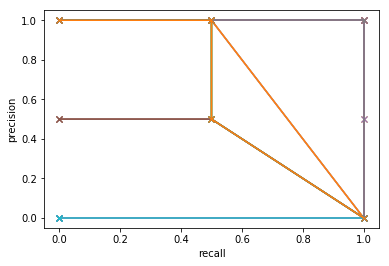

In [154]:
for i in range(32):
    plt.plot(recallss[i],precisionss[i],'x-')
    plt.xlabel('recall')
    plt.ylabel('precision')

(0, 1)

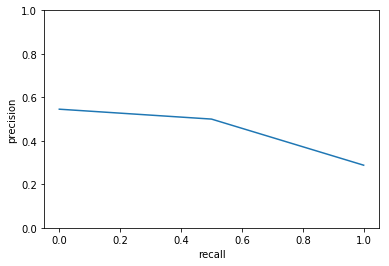

In [159]:
n0=n1=n2=0
psum0=[0] 
psum1=[0]
psum05=[0]
for i in range(33):
    for j in range(len(recallss[i])):
        if recallss[i][j]==0:
            psum0=psum0+precisionss[i][j]
            n0=n0+1
        if recallss[i][j]==1:
            psum1=psum1+precisionss[i][j]
            n1=n1+1
        if recallss[i][j]==0.5:
            psum05=psum05+precisionss[i][j]
            n2=n2+1
            
avep0=psum0/n0
avep1=psum1/n1
avep05=psum05/n2

plt.plot([0,0.5,1],[psum0/33, psum05/33, psum1/33])
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim(0, 1)

    

In [156]:
(psum1+psum05)*0.5/(2*33)+(psum05+psum0)*0.5/(2*33)

array([0.45833333])

In [141]:
def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.
    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)
    
    
plot_precision_recall(np.mean(APs), np.mean(precisionss), np.mean(recallss))   

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [ ]:
for i in range(32):
    plt.plot(recallss[i],precisionss[i],'x-')
    plt.xlabel('recall')
    plt.ylabel('precision')
    

In [ ]:
n0=n1=n2=0
psum0=[0] 
psum1=[0]
psum05=[0]
for i in range(33):
    for j in range(len(recallss[i])):
        if recallss[i][j]==0:
            psum0=psum0+precisionss[i][j]
            n0=n0+1
        if recallss[i][j]==1:
            psum1=psum1+precisionss[i][j]
            n1=n1+1
        if recallss[i][j]==0.5:
            psum05=psum05+precisionss[i][j]
            n2=n2+1
            
avep0=psum0/n0
avep1=psum1/n1
avep05=psum05/n2

In [ ]:
plt.plot([0,0.5,1],[psum0/33, psum05/33, psum1/33])
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim(0, 1)

In [ ]:
(psum1+psum05)*0.5/(2*33)+(psum05+psum0)*0.5/(2*33)

In [ ]:
arr=np.ma.empty((2,3))
arr
arr.mask=True
arr
arr[:0,:6] =

In [ ]:

for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset, inference_config,
                                       image_id, use_mini_mask=False)
    results = modeli.detect([image], verbose=0)
    r = results[0]
    if len(r['masks']) == 0: 
        pass
    else:
        try:
            gt_match, pred_match, overlaps=utils.compute_matches(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5, score_threshold=0.0)
            predmiss=predmiss+predmiss.loc[pred_match==-1].sum()
            predhit=predhit+predhit.loc[pred_match==1].sum()
        except Exception:
            pass


# df.loc[df.PROJECT == "A001", "HOURS"].sum()

In [ ]:
r['masks'].shape


In [ ]:
pred_match

In [ ]:
overlaps

In [ ]:
# r['masks']
gt_bbox

In [ ]:
indices = np.argsort(pred_scores)[::-1]

data_generator(dataset, config, shuffle=True, augment=False, augmentation=None,
                   random_rois=0, batch_size=1, detection_targets=False,
                   no_augmentation_sources=None):